# VGG19

## Create Embeddings

In [1]:
# Load images
import numpy as np
from PIL import Image
import os

# Training
image_folder = "images/training_imgs"

# Log all sets of images so they are in the same order
full_body_images = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith("fb.png")]
clothing_images = [file[:-6] + "c.png" for file in full_body_images]
full_body_raw = [file[:-6] + "fb-unedited.png" for file in full_body_images]

# Break into categories
clothing_labels = [file.split("/")[-1].split("-")[0].split("_") for file in clothing_images]
clothing_images = [Image.open(file) for file in clothing_images]
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

full_body_labels = [file.split("/")[-1].split("-")[0].split("_") for file in full_body_images]
full_body_images = [Image.open(file) for file in full_body_images]
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]

full_body_raw = [Image.open(file) for file in full_body_raw]

# Test
image_folder = "images/example_imgs"

# Break into categories
test_clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder)]

In [2]:
# Create embeddings
import tensorflow as tf

def sample_generator(dataset):
    for sample in dataset:
        yield tf.keras.applications.vgg19.preprocess_input(np.array(sample))

img_spec = tf.TensorSpec((488, 488, 3), float)
ds_clothing = tf.data.Dataset.from_generator(lambda: sample_generator(clothing_images), output_signature=img_spec).batch(32)
ds_outfit = tf.data.Dataset.from_generator(lambda: sample_generator(full_body_images), output_signature=img_spec).batch(32)
ds_test = tf.data.Dataset.from_generator(lambda: sample_generator(test_clothing_images), output_signature=img_spec).batch(32)

model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(488, 488, 3),
    pooling="avg"
)

clothing_embed = model.predict(ds_clothing)
full_body_embed = model.predict(ds_outfit)
test_embed = model.predict(ds_test)

2024-05-07 01:36:11.260268: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 01:36:11.305990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 01:36:11.965444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-07 01:36:12.835972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute cap

      2/Unknown 14s 103ms/step

I0000 00:00:1715060187.276098 1314324 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 750ms/step


2024-05-07 01:36:56.521777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ian/miniconda3/envs/tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 691ms/step


2024-05-07 01:37:24.329647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2024-05-07 01:37:27.329913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualize model embeddings

In [3]:
# Load images
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Break into categories
clothing_pca = PCA(n_components=2).fit(clothing_embed)
print(clothing_pca.explained_variance_ratio_, sum(clothing_pca.explained_variance_ratio_))
clothing_pca = clothing_pca.transform(clothing_embed)
clothing_tsne = TSNE().fit_transform(clothing_embed)

full_body_pca = PCA(n_components=2).fit(full_body_embed)
print(full_body_pca.explained_variance_ratio_, sum(full_body_pca.explained_variance_ratio_))
full_body_pca = full_body_pca.transform(full_body_embed)
full_body_tsne = TSNE().fit_transform(full_body_embed)

[0.20855163 0.1122476 ] 0.32079923152923584
[0.14777932 0.10261285] 0.2503921687602997


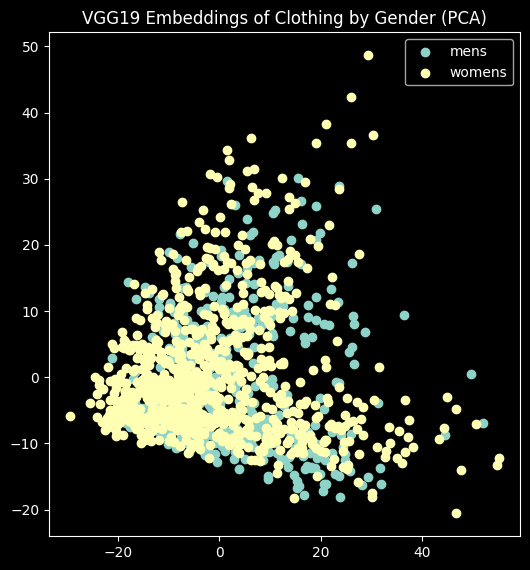

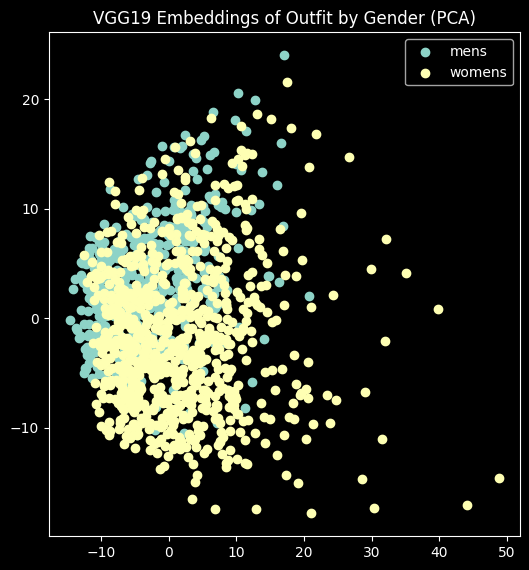

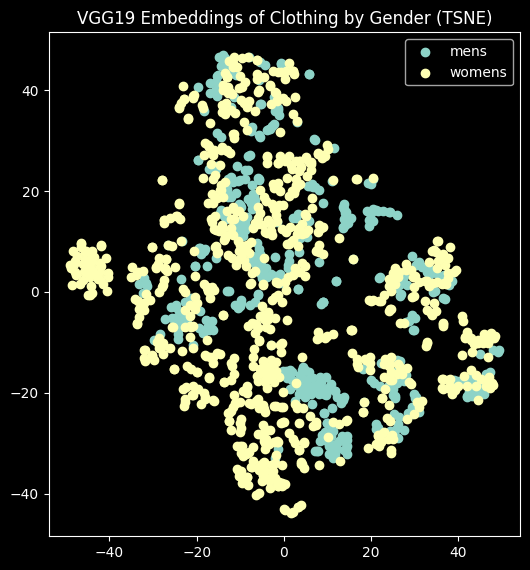

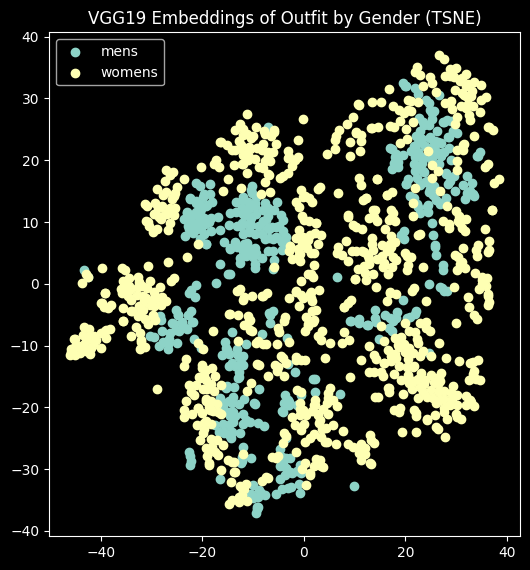

In [4]:
# Plot gendered items
import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Clothing by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Outfit by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Clothing by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Outfit by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

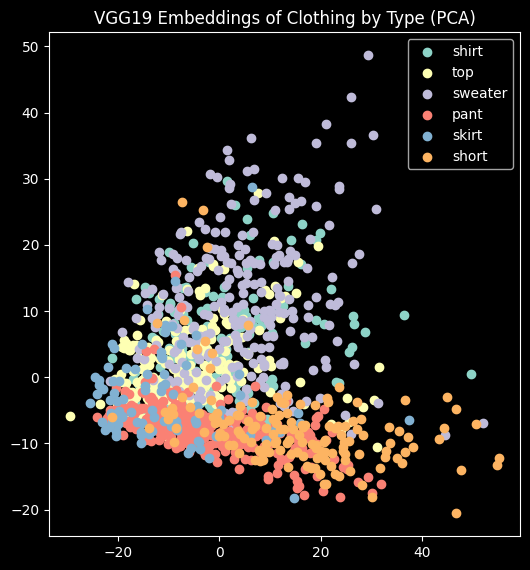

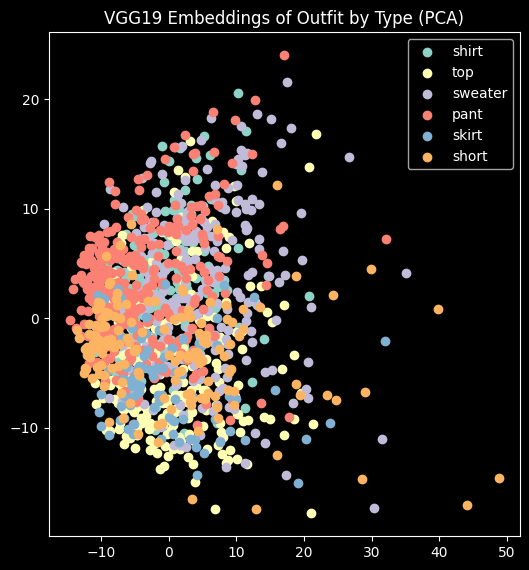

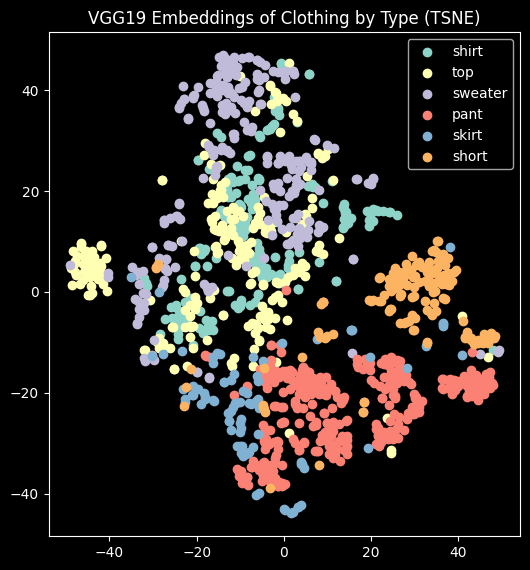

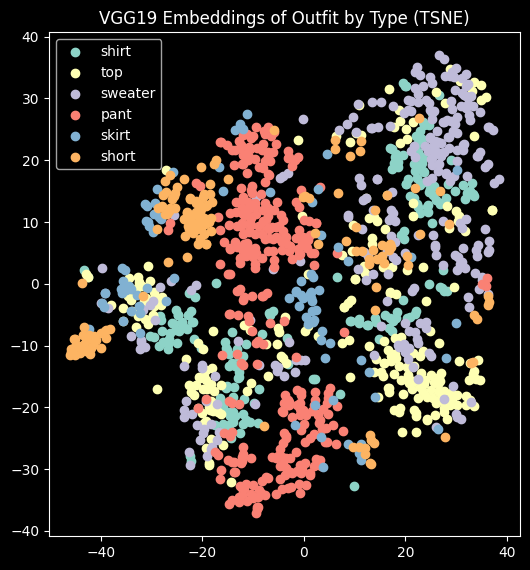

In [5]:
# Plot types of items

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Clothing by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Outfit by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Clothing by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Outfit by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

## Testing embeddings using KNN

In [6]:
from sklearn.model_selection import train_test_split

y_map = {"shirt": 0, "top": 0, "sweater": 1, "pant": 2, "skirt": 3, "short": 4}
y = np.array([y_map[label[2]] for label in clothing_labels])
X_train, X_test, y_train, y_test = train_test_split(clothing_embed, y, test_size=0.25)

In [7]:
# Run KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

matrix = confusion_matrix(y_test, knn.predict(X_test))
acc_per_class = matrix.diagonal()/matrix.sum(axis=1)

print(acc_per_class)

[0.94392523 0.80821918 1.         0.76190476 0.95348837]


## Plot demo outfits

In [8]:
# Refit KNN on all training

knn.fit(clothing_embed, y)

KNeighborsClassifier()

[2]
[[ 819 1167  266  663 1000]]
[0]
[[  33  174  184  984 1245]]
[4]
[[149 325 579  80 714]]
[0]
[[1147  184  862  259  710]]
[1]
[[1238  673   31  438  492]]


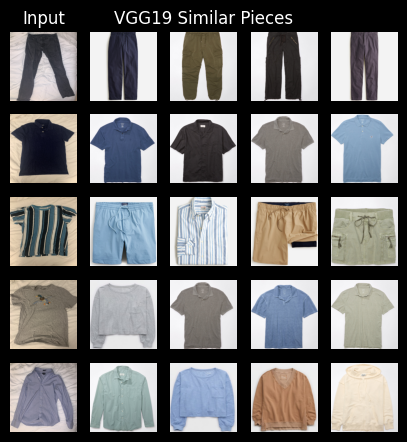

In [9]:
# Generate similar clothes

_, axs = plt.subplots(5, 5, figsize=(5,5.2))
axs[0, 0].set_title("Input")
axs[0, 2].set_title("VGG19 Similar Pieces")

for i, test_emb in enumerate(np.delete(test_embed, 1, axis=0)):
    print(knn.predict(np.reshape(test_emb, (1, -1))))
    axs[i, 0].axis("off")
    axs[i, 0].imshow(np.delete(test_clothing_images, 1, axis=0)[i], aspect="auto")

    _, inds = knn.kneighbors(np.reshape(test_emb, (1, -1)))
    print(inds)
    for j, ind in enumerate(inds[0][:4]):
        axs[i, j + 1].axis("off")
        axs[i, j + 1].imshow(clothing_images[ind], aspect="auto")

plt.show()

[2]
[[ 819 1167  266  663 1000]]
[0]
[[  33  174  184  984 1245]]
[4]
[[149 325 579  80 714]]
[0]
[[1147  184  862  259  710]]
[1]
[[1238  673   31  438  492]]


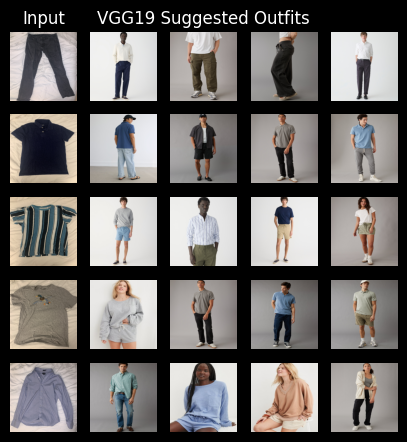

In [10]:
# Generate suggested outfits

_, axs = plt.subplots(5, 5, figsize=(5,5.2))
axs[0, 0].set_title("Input")
axs[0, 2].set_title("VGG19 Suggested Outfits")

for i, test_emb in enumerate(np.delete(test_embed, 1, axis=0)):
    print(knn.predict(np.reshape(test_emb, (1, -1))))
    axs[i, 0].axis("off")
    axs[i, 0].imshow(np.delete(test_clothing_images, 1, axis=0)[i], aspect="auto")

    _, inds = knn.kneighbors(np.reshape(test_emb, (1, -1)))
    print(inds)
    for j, ind in enumerate(inds[0][:4]):
        axs[i, j + 1].axis("off")
        axs[i, j + 1].imshow(full_body_raw[ind], aspect="auto")

plt.show()